In [17]:
import librosa
import librosa.display
import numpy
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.interpolate import interp1d 
import IPython.display as ipd
import aubio

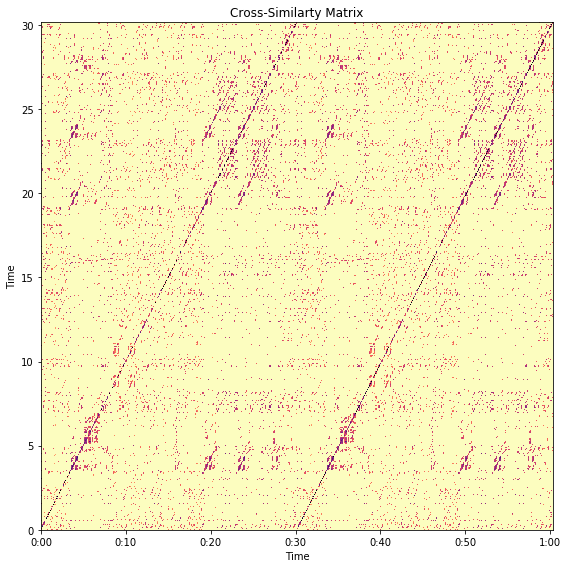

In [18]:
#Question 1.1: Cross-Similarity Matrix

hop_length = 512
y_ref, sr = librosa.load('disco/disco.00008.wav')
y_comp = np.concatenate((y_ref, y_ref), axis=None)
mfcc_ref = librosa.feature.mfcc(y=y_ref, sr=sr, hop_length=hop_length)
mfcc_comp = librosa.feature.mfcc(y=y_comp, sr=sr, hop_length=hop_length)
xsim = librosa.segment.cross_similarity(mfcc_comp, mfcc_ref, mode='affinity')
plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
librosa.display.specshow(xsim, x_axis='time', y_axis='time', cmap='magma_r', hop_length=hop_length)
plt.title('Cross-Similarty Matrix')
plt.tight_layout()

There are two diagonal lines running through the matrix that indicate continuous similarity in time.  Each line occupies one half of the matrix plot and are identical, indicating the repetition in one of the tracks.

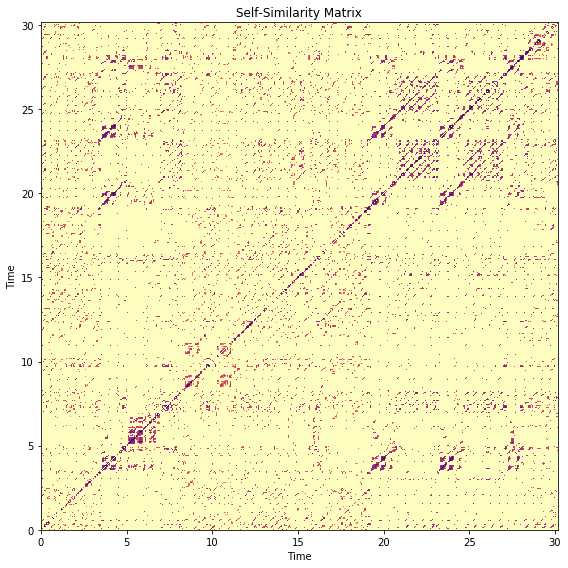

In [19]:
#Question 1.2: Self-Similarity Matrix

selfsim = librosa.segment.cross_similarity(mfcc_ref, mfcc_ref, mode='affinity')
plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
librosa.display.specshow(selfsim, x_axis='time', y_axis='time', cmap='magma_r', hop_length=hop_length)
plt.title('Self-Similarity Matrix')
plt.tight_layout()

At around 4 second into the song we hear the lyrics "found our" which make a strong impression on the self-similarity matrix.  These lyrics can be seen at the intersection of x=3 and y=19, 23, 27 (the same is true of the inverse and along the diagonal).  If we grab two audio fragments, one at 3 seconds and one at 19 seconds, we should hear the repetition.

In [20]:
rep1 = y_ref[3*22050:5*22050]
rep2 = y_ref[19*22050:21*22050]

ipd.Audio(rep1, rate=sr)

In [21]:
#Repetition at 19 seconds
ipd.Audio(rep2, rate=sr)

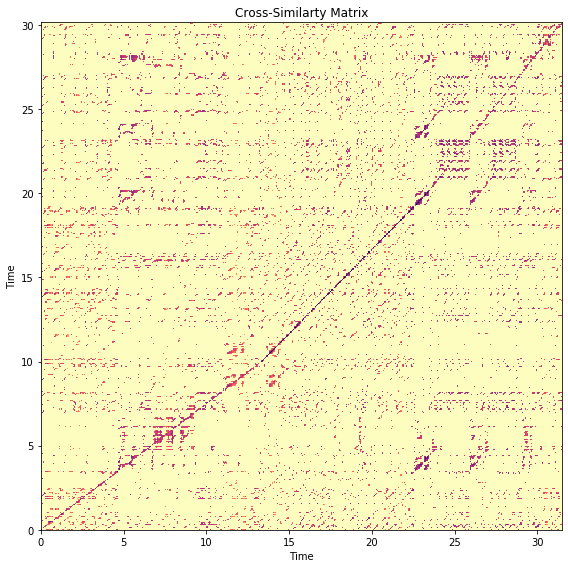

In [22]:
#Question 1.3: Time-Stretching

y_slow = y_ref[0:220500]
y_slow = librosa.effects.time_stretch(y_slow, 0.75)
y_norm = y_ref[220500:441000]
y_fast = y_ref[441000:]
y_fast = librosa.effects.time_stretch(y_fast, 1.25)
y_comp = np.concatenate((y_slow, y_norm, y_fast), axis=None)
mfcc_ref = librosa.feature.mfcc(y=y_ref, sr=sr, hop_length=hop_length)
mfcc_comp = librosa.feature.mfcc(y=y_comp, sr=sr, hop_length=hop_length)
xsim = librosa.segment.cross_similarity(mfcc_comp, mfcc_ref, mode='affinity')
plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
librosa.display.specshow(xsim, x_axis='time', y_axis='time', cmap='magma_r', hop_length=hop_length)
plt.title('Cross-Similarty Matrix')
plt.tight_layout()

The line appears to bend slightly, but upon closer exmination it appears to three distinct slopes stitched together.  The flatter slope shows how the similarities of the altered signal are lagging behind the original, and the steeper slope shows how the altered signal catches up to the original.  The middle slope is perfectly diagonal, but the similarities are delayed since the original signal is 'ahead' of the altered signal since the first 10 seconds of the altered was slowed down.

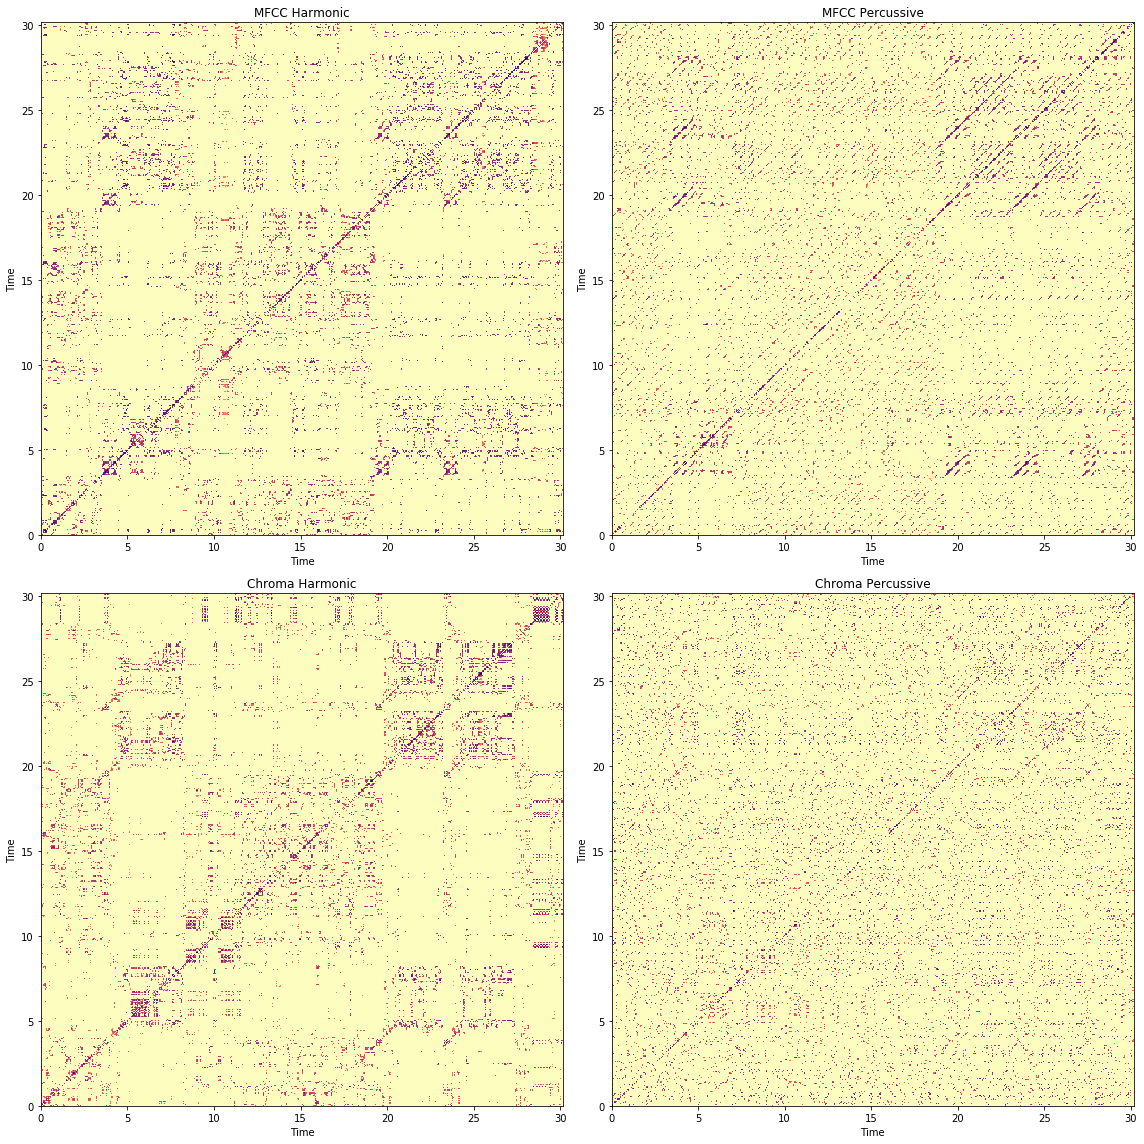

In [23]:
#Question 1.4: Harmonic/Percussive Separation

D = librosa.stft(y_ref)
D_harmonic, D_percussive = librosa.decompose.hpss(D)

#invert back to time domain for feature extraction
D_harmonic = librosa.istft(D_harmonic)
D_percussive = librosa.istft(D_percussive)

#perform feature extraction on original, percussive, and harmonic tracks
mfcc_harm = librosa.feature.mfcc(y=np.abs(D_harmonic), sr=sr, hop_length=hop_length)
mfcc_perc = librosa.feature.mfcc(y=D_percussive, sr=sr, hop_length=hop_length)
chroma_harm = librosa.feature.chroma_stft(y=D_harmonic, sr=sr, hop_length=hop_length)
chroma_perc = librosa.feature.chroma_stft(y=D_percussive, sr=sr, hop_length=hop_length)

#generate self-similarity matrices
selfsim1 = librosa.segment.cross_similarity(mfcc_harm, mfcc_harm, mode='affinity')
selfsim2 = librosa.segment.cross_similarity(mfcc_perc, mfcc_perc, mode='affinity')
selfsim3 = librosa.segment.cross_similarity(chroma_harm, chroma_harm, mode='affinity')
selfsim4 = librosa.segment.cross_similarity(chroma_perc, chroma_perc, mode='affinity')

#plot results
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
librosa.display.specshow(selfsim1, x_axis='time', y_axis='time', cmap='magma_r', hop_length=hop_length)
plt.title('MFCC Harmonic')
plt.subplot(2, 2, 2)
librosa.display.specshow(selfsim2, x_axis='time', y_axis='time', cmap='magma_r', hop_length=hop_length)
plt.title('MFCC Percussive')
plt.subplot(2, 2, 3)
librosa.display.specshow(selfsim3, x_axis='time', y_axis='time', cmap='magma_r', hop_length=hop_length)
plt.title('Chroma Harmonic')
plt.subplot(2, 2, 4)
librosa.display.specshow(selfsim4, x_axis='time', y_axis='time', cmap='magma_r', hop_length=hop_length)
plt.title('Chroma Percussive')
plt.tight_layout()

Chroma features are used for identifying pitch classes, so naturally it doesn't work very well with a percussive component.  It does do a great job of capturing self-similarity in the harmonic components.  MFCC works okay for both components, but the harmonic component seems to be closer to the original matrix in look.  Overall, these features seem to work better for harmonic components since the harmonic information has much more information in it (in terms of spectrum and energy).

In [24]:
#Question 1.5: Dyanmic Time Warping (SKIPPED)

In [25]:
#Question 2.1: Spleeter 4-stem

import warnings
warnings.filterwarnings("ignore")
from spleeter.separator import Separator
# Use audio loader explicitly for loading audio waveform :
from spleeter.audio.adapter import get_default_audio_adapter

separator = Separator('spleeter:4stems')
song_file_name = 'all_star.wav'

audio_loader = get_default_audio_adapter()
sample_rate = 44100
waveform, _ = audio_loader.load(song_file_name, sample_rate=sample_rate)

# Perform the separation :
prediction = separator.separate(waveform)

vocals = np.array(prediction["vocals"], dtype='f')
drums = np.array(prediction["drums"], dtype='f')
bass = np.array(prediction["bass"], dtype='f')
other = np.array(prediction["other"], dtype='f')

INFO:tensorflow:Using config: {'_model_dir': 'pretrained_models/4stems', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.7
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c31850e50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Apply unet for vocals_spectrogram
INFO:tensorflow:Apply unet for drums_spectrogram
INFO:tensorflow:Apply unet for bass_spectrog

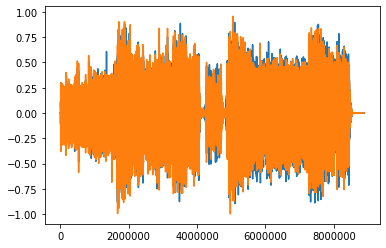

In [28]:
plt.plot(vocals)
plt.show()

ipd.Audio(vocals.T, rate=sample_rate)

The vocal track is pretty well isolated, but there are still a lot of sonic artifcacts from the other components.  The volume and spectrum has a noticeable change when the chorus starts, but it seems to correct itself after a few seconds.

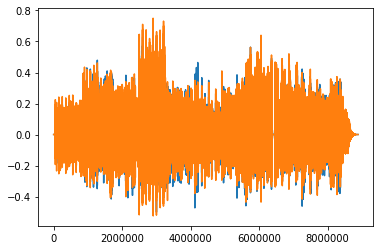

In [29]:
plt.plot(bass)
plt.show()

ipd.Audio(bass.T, rate=sample_rate)

The bass track was pretty buried in the instrumentation of this song, so it's not surprising that it would have be the most muffled of the stems.  However, it has a lot fewers artifcats compared to the vocal.  Still, the sound of the bass is not ideal.

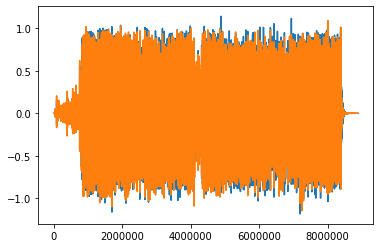

In [30]:
plt.plot(drums)
plt.show()

ipd.Audio(drums.T, rate=sample_rate)

The drums have a lot of high end artifcats from the guitar especially (it's even audible at some points).  The drum track is still recognizable, but it adds a lot of rhtyhmic components from other instruments that don't belong it.  Overall, it's the worst result of the bunch.

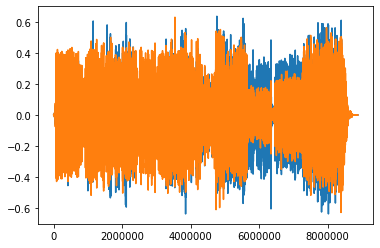

In [31]:
plt.plot(other)
plt.show()

ipd.Audio(other.T, rate=sample_rate)

For the case of other, it seems to be primarily the guitar and other embellishments.  A lot of artifacts like the drum track, but better results and more coherent as a stem track.

In [35]:
#Question 2.2: Pitch shift vocals

vocals_unedited, sr = librosa.load('output/vocals.wav', sr=44100)

vocals_ps = librosa.effects.pitch_shift(vocals_unedited, sr=sr, n_steps=4)

combined = drums + bass + other

ipd.Audio(vocals_ps + combined.T, rate=sr)

The results don't sound as jarring as I thought.  The major 3rd pitch shift doesn't cause too much dissonance, but it still sounds quite goofy.  Nevertheless, the combination works better than expected.

In [33]:
#Question 2.3: Pitch detection + drums

def pitch_yin(frame, srate):
    p = aubio.pitch("yin", len(frame), len(frame), srate)
    a = frame.astype("float32")
    return p(a)[0]

def pitch_track(signal, hopSize, winSize, extractor, srate): 
    offsets = np.arange(0, len(signal), hopSize)
    pitch_track = np.zeros(len(offsets))
    amp_track = np.zeros(len(offsets))
    
    for (m,o) in enumerate(offsets): 
        frame = signal[o:o+winSize]
        if len(frame) < winSize:
            np.pad(frame, (0, winSize - len(frame)), 'constant')
        pitch_track[m] = extractor(frame, srate)
        amp_track[m] = np.sqrt(np.mean(np.square(frame)))  

        if (pitch_track[m] > 1500): 
            pitch_track[m] = 0 
        
    return (amp_track, pitch_track)

# compute the pitch tracks 
(at, pt) = pitch_track(vocals_unedited, 512, 256, pitch_yin, sr)

def sonify(amp_track, pitch_track, srate, hop_size):

    times = np.arange(0.0, float(hop_size * len(pitch_track)) / srate,
                      float(hop_size) / srate)

    # sample locations in time (seconds)                                                      
    sample_times = np.linspace(0, np.max(times), int(np.max(times)*srate-1))

    # create linear interpolators for frequencies and amplitudes                              
    # so that we have a frequency and amplitude value for 
    # every sample 
    freq_interpolator = interp1d(times,pitch_track)
    amp_interpolator = interp1d(times,amp_track)

    # use the interpolators to calculate per sample frequency and                             
    # ampitude values                                                                         
    sample_freqs = freq_interpolator(sample_times)
    sample_amps  = amp_interpolator(sample_times)

    # create audio signal                                                                     
    audio = np.zeros(len(sample_times));
    T = 1.0 / srate
    phase = 0.0
    
    # update phase according to the sample frequencies 
    for i in range(1, len(audio)):
        audio[i] = sample_amps[i] * np.sin(phase)
        phase = phase + (2*np.pi*T*sample_freqs[i])

    return audio

pitched_audio = sonify(at, pt, sr, 512)
drums_mono = drums.sum(axis=1) / 2 #make audio mono so it combined with pitched audio
ipd.Audio(pitched_audio+drums_mono[:len(pitched_audio)],rate=sr)

The melody is accurate enough and the drums provide a good foundation that makes the song recognizable.  It's not enjoyable to listen to, but it is recognizable.

In [ ]:
#Question 2.4 and 2.5 SKIPPED